# Time series classification Part 2

In this notebook, we will try to adapt our TiDE+RIN model that we used in part 1 to predict the 100 next values of the feature '6'.

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.

In [ ]:
import torch
import pandas as pd

from darts import TimeSeries
from darts.models import TFTModel, NBEATSModel, TiDEModel
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse
from darts.datasets import ExchangeRateDataset

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Dataset description :

First of all, let's take a look at the '6' feature.

<Axes: xlabel='time'>

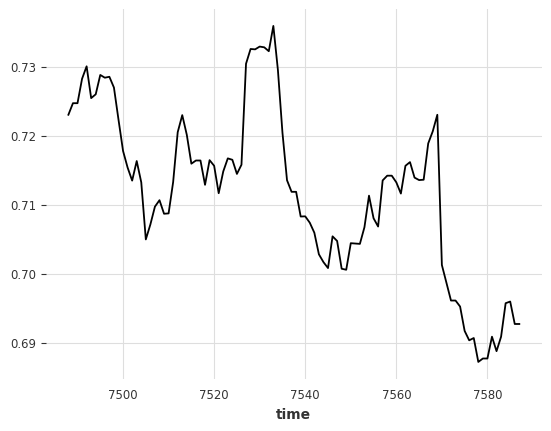

In [ ]:
series = ExchangeRateDataset().load()
df = series.pd_dataframe()
df = df["6"]
dernieres_valeurs = df.tail(100)
dernieres_valeurs.plot()

Now let's see all the features :

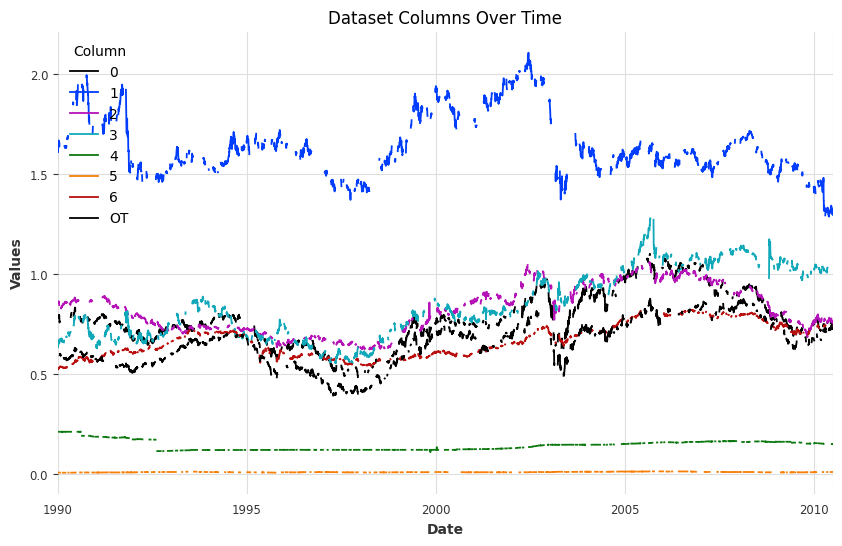

In [ ]:
df = pd.read_csv("exchange_rate_with_missing.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.plot(figsize=(10, 6))
plt.title('Dataset Columns Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend(title='Column')
plt.show()

## Dataset preprocessing :

To fill the gap in our dataset, let's use backward filling

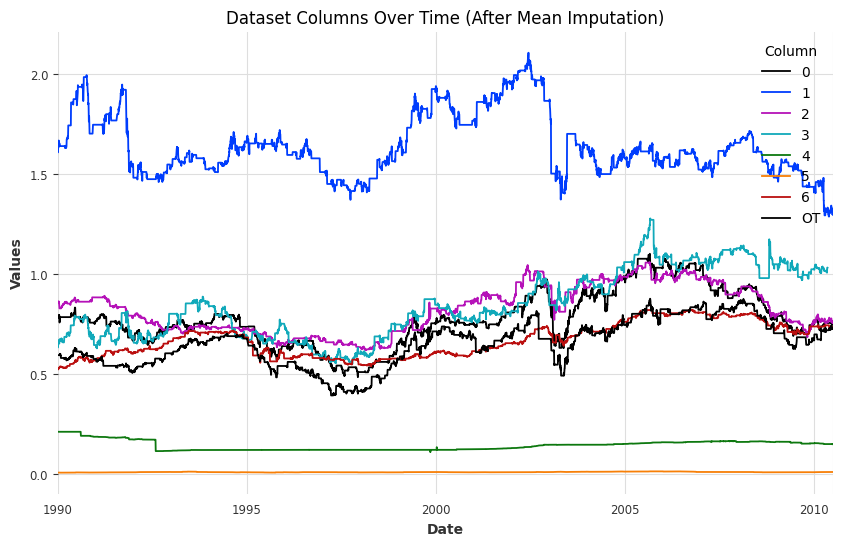

In [ ]:
df.fillna(method='bfill', inplace=True)
#df.drop(columns=["4", "5"], inplace=True)
df.plot(figsize=(10, 6))
plt.title('Dataset Columns Over Time (After Mean Imputation)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend(title='Column')
plt.show()

We can clearly see that the '4' and '5' features are not relevant. Let's delete them of our dataset.

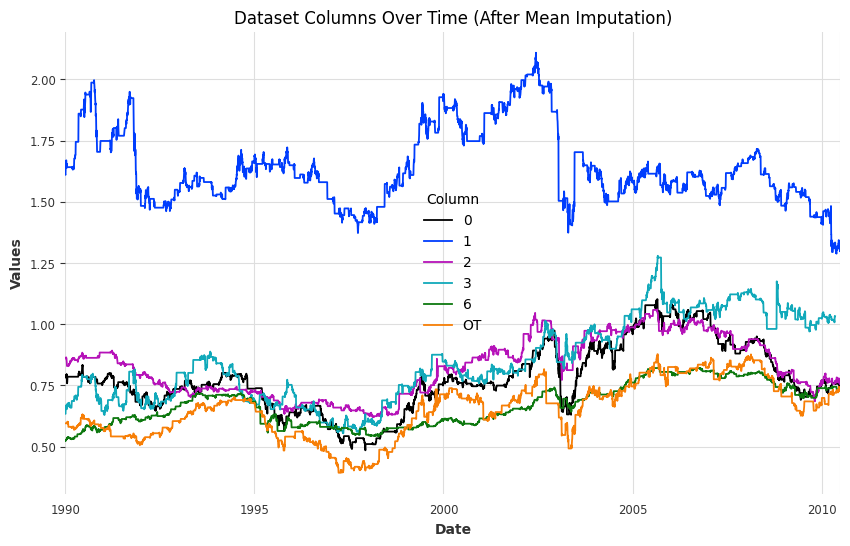

In [ ]:
df.fillna(method='bfill', inplace=True)
df.drop(columns=["4", "5"], inplace=True)
df.plot(figsize=(10, 6))
plt.title('Dataset Columns Over Time (After Mean Imputation)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend(title='Column')
plt.show()

The '1' feature doesn't look relevant too. Also, the '3' feature look good at the start but not so much at the end of our dataset and since we want to predict the 100 next values of '6', we decide to delete it too.

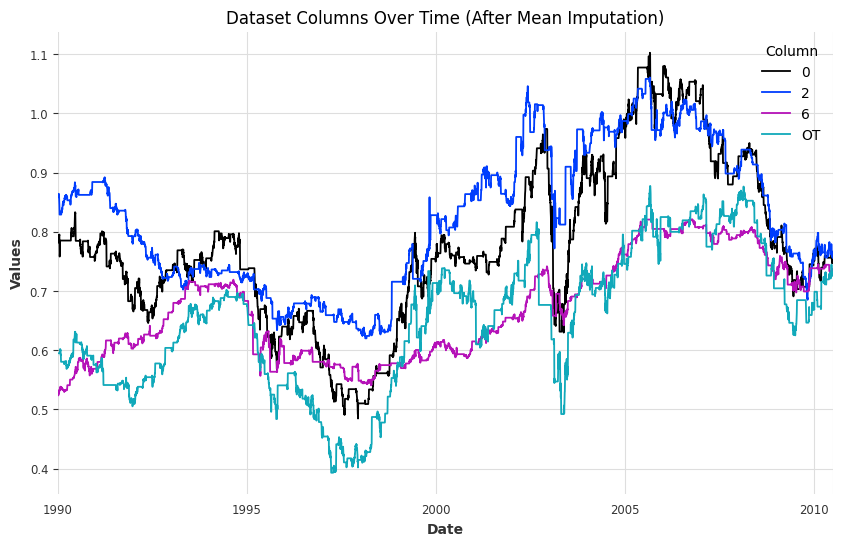

In [ ]:
df6 = df
df6.drop(columns=["1", "3"], inplace=True)
df6.plot(figsize=(10, 6))
plt.title('Dataset Columns Over Time (After Mean Imputation)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.grid(True)
plt.legend(title='Column')
plt.show()

## TiDE+RIN model configuration

Let's test the model used in part 1. We train it only on the '6' feature, the one that we have to predict.

In [ ]:
import numpy as np
import pandas as pd  # You need to import pandas here
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

df = df[['6']]

series = TimeSeries.from_dataframe(df)

train, val = series[:-100], series[-100:]


In [ ]:
from darts.models.forecasting.tide_model import TiDEModel
from darts.dataprocessing.transformers import Scaler


train_scaler = Scaler()
scaled_series = train_scaler.fit_transform(series)
scaled_train = train_scaler.fit_transform(train)

tide = TiDEModel(
    input_chunk_length=512,
    output_chunk_length=100,
    num_encoder_layers=2,
    num_decoder_layers=2,
    decoder_output_dim=32,
    hidden_size=256,
    temporal_decoder_hidden=16,
    use_layer_norm=True,
    use_reversible_instance_norm=True,
    dropout=0.5)

In [ ]:
tide.fit(
    scaled_series,
    epochs=15
)

Training: |          | 0/? [00:00<?, ?it/s]

TiDEModel(output_chunk_shift=0, num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=256, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=16, use_layer_norm=True, dropout=0.5, use_static_covariates=True, input_chunk_length=512, output_chunk_length=100)

In [ ]:
scaled_pred_tide = tide.predict(n=100)

pred_tide = train_scaler.inverse_transform(scaled_pred_tide)

Predicting: |          | 0/? [00:00<?, ?it/s]

## Final result

In [ ]:
preds_df = pred_tide.pd_dataframe()

In [ ]:
plt.plot(preds_df.index, preds_df["6"], label='TiDE', ls='--', color='green')
plt.plot(preds_df.index, dernieres_valeurs, label='Actual', ls='--', color='red')
plt.tight_layout()

In [ ]:
pred_tide_df = pred_tide.pd_dataframe()
pred_tide_df['Id'] = range(100)
pred_tide_df


In [ ]:
pred_tide_df = pred_tide_df.rename(columns={"6": "Prediction"})
pred_tide_df

In [ ]:
pred_tide_df.to_csv('predictions.csv', index=False)


We save our result in a csv that we submit to the competition

Best result so far : mae = 0.0095
